In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/NERSC/analyze-iris`


In [2]:
using Revise, JSON, Dates, Plots, StatsBase, TimeZones

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [3]:
struct Reservation
    name::String
    nodelist::String
    starttime::String
    endtime::String
    nodecount::Int64
    features::String
    acccount::String
end

In [4]:
ue_seconds(x::String) = Int64(
    floor(datetime2unix(
            DateTime(ZonedDateTime(
                DateTime(x, "yyyy-mm-ddTHH:MM:SS"),
                tz"America/Los_Angeles")
                , UTC
            )
    ))
)
start(r::Reservation)  = ue_seconds(r.starttime)
finish(r::Reservation) = ue_seconds(r.endtime)

finish (generic function with 1 method)

In [5]:
nid_list_start(x::AbstractString) = occursin("[", x) ? findfirst("[", x)[1] + 1 : 4
nid_list_end(x::AbstractString) = occursin("[", x) ? findfirst("]", x)[1] - 1 : length(x)
nid_list(x::AbstractString) = x[nid_list_start(x):nid_list_end(x)]

function nids(x::AbstractString)
    nids = Int64[]
    r = split(nid_list(x), ",")
    for sr in r
        s = split(sr, "-")
        if length(s) < 2
            push!(nids, parse(Int64, s[1]))
        else
            a, b = s
            append!(nids, collect(parse(Int64, a) : parse(Int64, b)))
        end
    end
    return nids
end

nids(r::Reservation) = nids(r.nodelist)

nids (generic function with 2 methods)

In [6]:
struct Job
    id::Int64
    startTime::Int64
    endTime::Int64
    submitTime::Int64
    jobAccount::String
    allocCpus::Int64
    allocNodes::Int64
    qos::String
    name::String
    nodes::Vector{Int64}
    partition::String

    function Job(job::Dict{String, Any})
        new(
            job["jobId"],
            job["startTime"],
            job["endTime"],
            job["submitTime"],
            job["jobAccount"],
            job["allocCpus"],
            job["allocNodes"],
            job["qos"],
            job["name"],
            nids(job["nodes"]),
            job["partition"]
        )
    end
    Job(args...) = new(args...)
end

id(j::Job)        = j.id
start(j::Job)     = j.startTime
finish(j::Job)    = j.endTime
submit(j::Job)    = j.submitTime
account(j::Job)   = j.jobAccount
cpus(j::Job)      = j.allocCpus
nodes(j::Job)     = j.allocNodes
qos(j::Job)       = j.qos
name(j::Job)      = j.name
nids(j::Job)      = j.nodes
partition(j::Job) = j.partition

duration(j::Job) = finish(j) - start(j)
waittime(j::Job) = start(j) - submit(j)

function Job(j::Job, r::Reservation)
    
    res_nodes = intersect(nids(j), nids(r))
    
    if length(nids(j)) == length(res_nodes)
        return j
    end

    n = cpus(j) / nodes(j)

    Job(
        id(j),
        start(j),
        finish(j),
        submit(j),
        account(j),
        length(res_nodes)*n,
        length(res_nodes),
        qos(j),
        name(j),
        res_nodes,
        partition(j)
    )
end

Job

In [7]:
function partitions(jobs::Array{Job})
    partitions = String[]
    for j in jobs
        if !(partition(j) in partitions)
            push!(partitions, partition(j))
        end
    end
    return partitions
end

import Base.get

function get(jobs::Array{Job}, ID::Integer)
    for j in jobs
        if id(j) == ID
            return j
        end
    end
end

function get(jobs::Array{Dict{String, Any}}, ID::Integer)
    for j in jobs
        if j["jobId"] == ID
            return j
        end
    end
end

get (generic function with 77 methods)

In [8]:
struct History
    compute::Vector{Int64}
    waiting::Vector{Int64}
    nodes::Dict{Int64, Vector{Int64}}
    start::Int64
    finish::Int64
    
    function History(r::Reservation)
        s = start(r)
        f = finish(r)

        compute = zeros(Int64, f - s)
        waiting = zeros(Int64, f - s)
        nodes = Dict{Int64, Vector{Int64}}()
        for n in nids(r)
            nodes[n] = zeros(Int64, f - s)
        end

        new(compute, waiting, nodes, s, f)
    end
end

function add!(h::History, j::Job)
    start_job = max(h.start, start(j)) - h.start + 1
    end_job   = min(h.finish, finish(j)) - h.start

    n_cpus = cpus(j)
    for sec = start_job:end_job
        h.compute[sec] += n_cpus
    end
    
    cpus_per_node = n_cpus/nodes(j)
    
    for nid in nids(j)
        for sec = start_job:end_job
            h.nodes[nid][sec] += cpus_per_node
        end
    end
    
    submit_job = max(h.start, submit(j)) - h.start + 1
    
    for sec = submit_job:min(start_job, h.finish - h.start)
        h.waiting[sec] += n_cpus
    end
end

function max_node(h::History)
    m = 0
    for k in keys(h.nodes)
        m = max(m, maximum(h.nodes[k]))
    end
    return m
end 

max_node (generic function with 1 method)

In [9]:
reservations = Dict(
    "lx31_1"  => Reservation(
        "lx31_processing_1",
        "nid00[800-831]",
        "2021-07-23T10:00:00", "2021-07-23T22:00:00",
        32, "haswell", "lcls"
    ),
    "lx31_1a" => Reservation(
        "lx31_processing_1a", 
        "nid0[1161,1203-1205,1330-1332,1393-1403,1423-1426,1454-1460,1463-1464,1492]",
        "2021-07-23T23:07:19", "2021-07-24T11:07:19",
        32, "haswell", "lcls"
    ),
    "lx31_2"  => Reservation(
        "lx31_processing_2",
        "nid0[0792,0800-0808,0810-0811,0813-0831,0845,1325-1326,1929-1931,1969,2010,2013,2018,2026-2027,2081-2084,2105-2106,2146-2147,2150-2151,2161,2219,2221-2225,2228,2293-2295]",
        "2021-07-25T10:00:00", "2021-07-26T10:00:00",
        64, "haswell", "lcls"
    ),
    "lv07_1"  => Reservation(
        "lv07_processing_1",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-07-29T10:00:00", "2021-07-29T22:00:00",
        64, "haswell", "lcls"
    ),
    "lv07_2"  => Reservation(
        "lv07_processing_2",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-07-30T10:00:00", "2021-07-30T22:00:00",
        64, "haswell", "lcls"),
    "lv07_3"  => Reservation(
        "lv07_processing_3",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-07-31T10:00:00", "2021-07-31T22:00:00",
        64, "haswell", "lcls"),
    "lv07_4"  => Reservation(
        "lv07_processing_4",
        "nid00[792-795,800-831,845,847-848,852-876]",
        "2021-08-01T10:00:00", "2021-08-01T22:00:00",
        64, "haswell", "lcls"),
    "p203_1"  => Reservation(
        "p203_processing_1",
        "nid00[792-795,800-827]",
        "2021-08-01T22:00:00", "2021-08-02T10:00:00",
        32, "haswell", "lcls"),
    "p203_2"  => Reservation(
        "p203_processing_2",
        "nid00[792-795,800-827]",
        "2021-08-02T22:00:00", "2021-08-03T12:00:00",
        32, "haswell", "lcls"),
    "p203_3"  => Reservation(
        "p203_processing_2",
        "nid00[792-795,800-828,860,876-882,884,902-910,913-914,924-926,928-929,935,947-949,952-953]",
        "2021-08-02T22:00:00", "2021-08-03T12:00:00",
        64, "haswell", "lcls")
)

Dict{String, Reservation} with 10 entries:
  "lv07_2"  => Reservation("lv07_processing_2", "nid00[792-795,800-831,845,847-…
  "lv07_4"  => Reservation("lv07_processing_4", "nid00[792-795,800-831,845,847-…
  "lv07_1"  => Reservation("lv07_processing_1", "nid00[792-795,800-831,845,847-…
  "lv07_3"  => Reservation("lv07_processing_3", "nid00[792-795,800-831,845,847-…
  "p203_2"  => Reservation("p203_processing_2", "nid00[792-795,800-827]", "2021…
  "lx31_1"  => Reservation("lx31_processing_1", "nid00[800-831]", "2021-07-23T1…
  "p203_1"  => Reservation("p203_processing_1", "nid00[792-795,800-827]", "2021…
  "lx31_1a" => Reservation("lx31_processing_1a", "nid0[1161,1203-1205,1330-1332…
  "lx31_2"  => Reservation("lx31_processing_2", "nid0[0792,0800-0808,0810-0811,…
  "p203_3"  => Reservation("p203_processing_2", "nid00[792-795,800-828,860,876-…

In [10]:
lx31_jobs = open(joinpath("data", "sacct", "lx31_jobs.json"), "r") do f
    JSON.parse(f)
end

lv07_jobs = open(joinpath("data", "sacct", "lv07_jobs.json"), "r") do f
    JSON.parse(f)
end

p203_jobs = open(joinpath("data", "sacct", "p203_jobs.json"), "r") do f
    JSON.parse(f)
end

admin_comments = merge(lx31_jobs, lv07_jobs, p203_jobs)
admin_comments_flat = Dict{String, Any}[]
jobs = Dict{String, Vector{Any}}()
jobs_flat = Job[]
for res in keys(admin_comments)
    if res == "p203_2"
        println("Skipping $(res)")
        continue
    end
    
    jobs[res] = Job[]
    for job in admin_comments[res]
        j = Job(job)
        j_int = Job(j, reservations[res])
        push!(jobs[res], j_int)
        push!(jobs_flat, j_int)
        push!(admin_comments_flat, job)
    end
end

Skipping p203_2


In [11]:
qwait(j::Job) = start(j) - submit(j)

qwait (generic function with 1 method)

In [12]:
rjobs  = Job.(lv07_jobs["lv07_3"])
rstart = start(reservations["lv07_3"])

1627750800

In [13]:
ljobs = filter(j->account(j)=="lcls", rjobs)

294-element Vector{Job}:
 Job(44987837, 1627752676, 1627752795, 1627752669, "lcls", 1024, 16, "resv", "LCLS_EXP", [852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867], "resv")
 Job(44987839, 1627752676, 1627752762, 1627752670, "lcls", 1024, 16, "resv", "LCLS_EXP", [800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815], "resv")
 Job(44987850, 1627752687, 1627752803, 1627752681, "lcls", 64, 1, "resv", "LCLS_EXP", [847], "resv")
 Job(44988807, 1627754056, 1627754225, 1627754049, "lcls", 64, 1, "resv", "LCLS_EXP", [847], "resv")
 Job(44988808, 1627754057, 1627754220, 1627754050, "lcls", 64, 1, "resv", "LCLS_EXP", [848], "resv")
 Job(44988809, 1627754064, 1627754195, 1627754051, "lcls", 64, 1, "resv", "LCLS_EXP", [792], "resv")
 Job(44988811, 1627754064, 1627754297, 1627754051, "lcls", 64, 1, "resv", "LCLS_EXP", [793], "resv")
 Job(44988812, 1627754065, 1627754256, 1627754052, "lcls", 64, 1, "resv", "LCLS_EXP", [794], "resv")
 Job(449888

In [57]:
sjobs = filter(j->submit(j) > rstart + 2.0*60*60 && submit(j) < rstart + 7.4*60*60, ljobs)

99-element Vector{Job}:
 Job(44991667, 1627761053, 1627761124, 1627761044, "lcls", 1024, 16, "resv", "LCLS_EXP", [852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867], "resv")
 Job(44991670, 1627761069, 1627761139, 1627761062, "lcls", 1024, 16, "resv", "LCLS_EXP", [800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815], "resv")
 Job(44992111, 1627761551, 1627761719, 1627761542, "lcls", 1024, 16, "resv", "LCLS_EXP", [852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867], "resv")
 Job(44992112, 1627761551, 1627761688, 1627761545, "lcls", 1024, 16, "resv", "LCLS_EXP", [800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815], "resv")
 Job(44992133, 1627761612, 1627761665, 1627761598, "lcls", 1024, 16, "resv", "LCLS_EXP", [816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831], "resv")
 Job(44992136, 1627761612, 1627761669, 1627761601, "lcls", 1024, 16, "resv", "LCL

In [58]:
qw = qwait.(sjobs)/60
qt = (submit.(sjobs).-rstart)/60^2
;

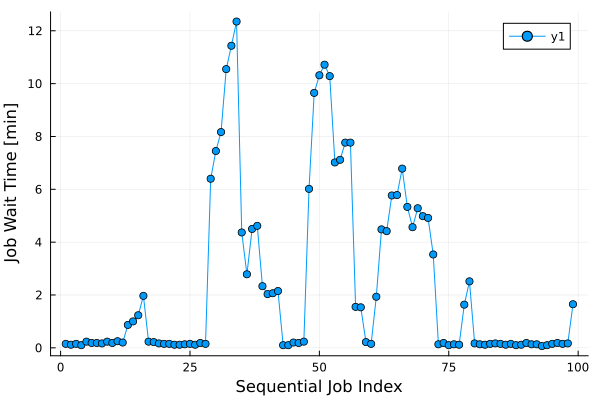

In [59]:
p = plot(qw, shape=:circle, xlabel="Sequential Job Index", ylabel="Job Wait Time [min]")
# savefig("wait.png")
p

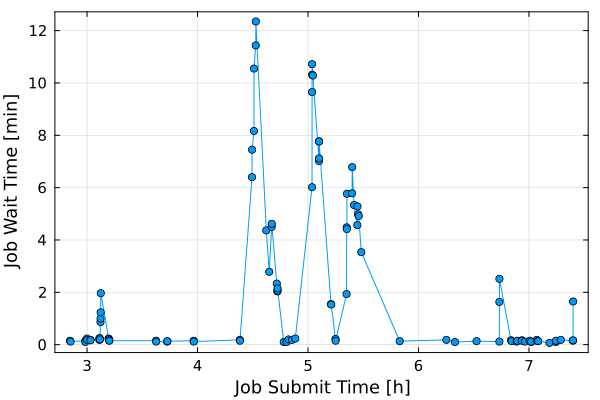

In [62]:
plot(
    qt, qw, shape=:circle, 
    xlabel="Job Submit Time [h]",
    ylabel="Job Wait Time [min]"
)
p = plot!(
    legend=false, grid=true,
    box=:on, tickfont=font(10), guidefont=font(12), legendfont=font(10)
)

savefig(joinpath("figures", "lv07_day3_preem_wait_time.pdf"))

p

In [19]:
sjobs[6]

Job(44992136, 1627761612, 1627761669, 1627761601, "lcls", 1024, 16, "resv", "LCLS_EXP", [792, 793, 794, 795, 845, 847, 848, 868, 869, 870, 871, 872, 873, 874, 875, 876], "resv")

In [20]:
qwait(sjobs[6])/60

0.18333333333333332

In [21]:
j = sjobs[6]

Job(44992136, 1627761612, 1627761669, 1627761601, "lcls", 1024, 16, "resv", "LCLS_EXP", [792, 793, 794, 795, 845, 847, 848, 868, 869, 870, 871, 872, 873, 874, 875, 876], "resv")

In [22]:
id(j)

44992136

In [23]:
j_ac = filter(x->x["jobId"]==id(j), admin_comments_flat)

1-element Vector{Dict{String, Any}}:
 Dict("startTime" => 1627761612, "jobDerivedExitCode" => 0, "submitTime" => 1627761601, "endTime" => 1627761669, "gresRequest" => "cpu=512,mem=1888G,node=16,billing=512,bb/datawarp=20624M", "tresRequest" => "1=1024,2=1933312,3=18446744073709551614,4=16,5=1024,1002=20624", "allocCpus" => 1024, "priority" => 1, "batchHost" => "nid00792", "jobExitCode" => 0…)

In [24]:
JSON.print(j_ac[1], 4)

{
    "startTime": 1627761612,
    "jobDerivedExitCode": 0,
    "submitTime": 1627761601,
    "endTime": 1627761669,
    "gresRequest": "cpu=512,mem=1888G,node=16,billing=512,bb/datawarp=20624M",
    "tresRequest": "1=1024,2=1933312,3=18446744073709551614,4=16,5=1024,1002=20624",
    "allocCpus": 1024,
    "priority": 1,
    "batchHost": "nid00792",
    "jobExitCode": 0,
    "licenses": "cscratch1:1",
    "jobId": 44992136,
    "reservation": "lv07_processing_3",
    "allocNodes": 16,
    "jobAccount": "lcls",
    "gresUsed": "craynetwork:64",
    "name": "LCLS_EXP",
    "packJobId": 0,
    "stderrPath": "/global/cscratch1/sd/cctbx/mfxlv0719/common/results/r0114/001_rg006/submit_err.log",
    "stdoutPath": "/global/cscratch1/sd/cctbx/mfxlv0719/common/results/r0114/001_rg006/submit_out.log",
    "resizing": 0,
    "shifterImage": "8267e933df06541f2462f72683581835eaaa4da641dd3ee185dcff90ac17fe4b",
    "burstBuffer": "#DW jobdw capacity=10GB access_mode=striped type=scratch\n#DW stage_out